# Работа №1 - Поиск ассоциативных правил

_Вариант 5. Сформировать набор из 30 транзакций на основе продуктов, употребляемых на завтрак, обед и ужин._

In [1]:
#! echo '[["Мясо", "Соус", "Вино"],["Мясо", "Соус", "Картофель", "Масло"],["Картофель", "Масло"],["Картофель", "Масло"],["Вино", "Яйца", "Бекон"],["Овощи", "Мясо", "Специи"],["Яйца", "Бекон", "Овощи", "Мясо", "Специи"],["Яйца", "Бекон", "Овощи", "Мясо", "Специи"],["Лапша", "Кетчуп"],["Пельмени", "Майонез", "Кетчуп"],["Пельмени", "Майонез", "Кетчуп"],["Овощи", "Пельмени", "Майонез", "Кетчуп"],["Овощи", "Соус", "Вино"],["Кетчуп"],["Кетчуп", "Лапша", "Пельмени", "Майонез"],["Кетчуп", "Лапша", "Пельмени", "Майонез"],["Кетчуп", "Лапша", "Мясо", "Соус", "Вино"],["Овощи", "Мясо", "Соус", "Вино"],["Майонез"],["Вино"],["Овощи", "Масло"],["Овощи", "Масло", "Картофель"],["Овощи", "Масло", "Картофель", "Мясо", "Соус"],["Овощи", "Бекон", "Яйца"],["Бекон", "Яйца"],["Яйца", "Кетчуп", "Лапша"],["Мясо"],["Мясо", "Масло"],["Мясо", "Масло", "Картофель"],["Масло", "Картофель"]]' > data/data_set.json
#! curl https://raw.githubusercontent.com/viktree/curly-octo-chainsaw/master/BreadBasket_DMS.csv > ./data/BreadBasket_DMS.csv
#! pip3 install apriori_python efficient-apriori fpgrowth-py pyarmviz pandas numpy pyarmviz 

In [2]:
from lib import datasets
from pandas import pandas
from fpgrowth_py import fpgrowth
from efficient_apriori import apriori as e_apriori
from apriori_python import apriori as apriori

In [3]:
repo_ds = datasets.from_csv("./data/BreadBasket_DMS.csv")
test_ds = datasets.from_json("./data/data_set.json")

## Формирование баз ассоциативных правил

In [4]:
_, test_rules = apriori(test_ds, minSup=0.15, minConf=0.6)
_, repo_rules_60 = apriori(repo_ds, minSup=0.01, minConf=0.6)
_, repo_rules_80 = apriori(repo_ds, minSup=0.01, minConf=0.8)
repo_rules_60

[[{'Toast'}, {'Coffee'}, 0.7044025157232704]]

In [5]:
_, test_rules_e = e_apriori(test_ds, min_support=0.15, min_confidence=0.6)
_, repo_rules_e_60 = e_apriori(repo_ds, min_support=0.01, min_confidence=0.6)
_, repo_rules_e_80 = e_apriori(repo_ds, min_support=0.01, min_confidence=0.8)
list(map(lambda x: (x, x.confidence), repo_rules_e_60))

[({Toast} -> {Coffee}, 0.7044025157232704)]

In [6]:
_, test_rules_fpg = fpgrowth(test_ds, minSupRatio=0.15, minConf=0.6)
_, repo_rules_fpg_60 = fpgrowth(repo_ds, minSupRatio=0.01, minConf=0.6)
_, repo_rules_fpg_80 = fpgrowth(repo_ds, minSupRatio=0.01, minConf=0.8)
repo_rules_fpg_60

[[{'Toast'}, {'Coffee'}, 0.7044025157232704]]

## Ручные расчёты

In [7]:
from lib import associative_rules
r = associative_rules.compute(test_ds)
r[('Соус', 'Вино')]

{'support': 0.13333333333333333,
 'confidence': 0.6666666666666666,
 'significance': 3.96}

## Визуализация правил

In [ ]:
from PyARMViz import PyARMViz
# PyARMViz.metadata_scatter_plot(test_rules_e)
rules = map(PyARMViz.Rule.generate_rule_from_rule, test_rules_e)
adjacency_graph_plotly(rules)

## Оценка времени формирования

In [24]:
from time import time
def measure(action):
    start = time()
    result = action()
    end = time()
    return end - start, result

confidence_probes = [ x / 10 for x in range(1, 11, 1) ]
algorithms = [
    lambda conf: lambda: fpgrowth(repo_ds, minSupRatio=0.01, minConf=conf),
    lambda conf: lambda: e_apriori(repo_ds, min_support=0.01, min_confidence=conf),
    lambda conf: lambda: apriori(repo_ds, minSup=0.01, minConf=conf)
]
result = {}
for conf in confidence_probes:
    result[conf] = {}
    for n, algorithm in enumerate(algorithms):
        elapsed, _ = measure(algorithm(conf))
        result[conf][n] = elapsed
result

{0.1: {0: 0.2200009822845459, 1: 0.26099538803100586, 2: 0.30499815940856934},
 0.2: {0: 0.2020273208618164, 1: 0.240997314453125, 2: 0.2854428291320801},
 0.3: {0: 0.23169684410095215, 1: 0.24402928352355957, 2: 0.2882523536682129},
 0.4: {0: 0.1979982852935791, 1: 0.24902725219726562, 2: 0.28699779510498047},
 0.5: {0: 0.19297075271606445, 1: 0.2516927719116211, 2: 0.2740962505340576},
 0.6: {0: 0.18697214126586914, 1: 0.26800012588500977, 2: 0.27602481842041016},
 0.7: {0: 0.18600058555603027, 1: 0.2449967861175537, 2: 0.2859673500061035},
 0.8: {0: 0.19277453422546387, 1: 0.24899840354919434, 2: 0.27602696418762207},
 0.9: {0: 0.18599796295166016, 1: 0.2594766616821289, 2: 0.279998779296875},
 1.0: {0: 0.18902826309204102, 1: 0.24799823760986328, 2: 0.28600025177001953}}

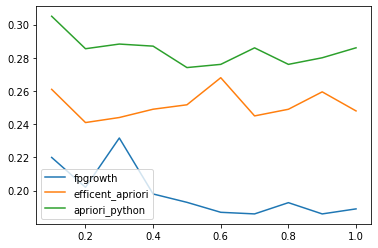

In [36]:
import matplotlib.pyplot as plt
x = confidence_probes
y0 = list(map(lambda conf: result[conf][0] ,result))
y1 = list(map(lambda conf: result[conf][1] ,result))
y2 = list(map(lambda conf: result[conf][2] ,result))
plt.plot(x, y0, label="fpgrowth")
plt.plot(x, y1, label="efficent_apriori")
plt.plot(x, y2, label="apriori_python")
plt.legend()
plt.show()